In [7]:
import fwiVis.fwiVis as fv #somehow not including updates to code? 

import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
import zarr #Didn't build into the env, needed to run "mamba install -c conda-forge zarr" took awhile, and was killed w/out mamba. Wait, it actually only worked with pip? 
import rasterio
from rasterio.plot import plotting_extent
import datetime as dt
from datetime import timedelta, date
#import imageio ## Need a diff script for image porcessing. 
#conda install -c conda-forge netCDF4 #maybe pip install? May have already been satisfied
# pip install h5netcdf


In [2]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2021, 8, 1)
end_dt = date(2021, 9, 30)
dates = []
for dt in daterange(start_dt, end_dt):
    date = dt.strftime("%Y%m%d")
    #print(date)
    dates.append(date)

In [3]:
#s3.ls("s3://veda-data-store-staging/EIS/COG/LIS_FORC_FWI_WEST_US/FWI")

In [5]:
fwi = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_FORC_FWI_WEST_US/FWI/LIS_FWI_COMP_20UTC_200207040000.d01.FWI.cog")

/tmp/ipykernel_8679/388185563.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  fwi = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_FORC_FWI_WEST_US/FWI/LIS_FWI_COMP_20UTC_200207040000.d01.FWI.cog")


In [6]:
#fwi.plot()

min_lat = 38.5
max_lat = 39
min_lon = -121
max_lon = -119.50

subset = fwi.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
#subset.plot()


In [8]:
files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/") # This will update through time. Not nessisary now because focus on 2019
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map, path_s3 = "veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/")
stations
st_dict = stations[['Lat', 'Lon']].to_dict('records')

#

foi = [{"Lat":38.586 , 
        "Lon":-120.537833 
    
}]
foi = pd.DataFrame(foi)
st_cls = fv.closest(st_dict, foi)
st = fv.get_st(lat = st_cls["Lat"], lon = st_cls["Lon"], stations = stations)

#gdf = gdf.sort_values(by = ['t']) ## Need to sort or timeseries jumps around
#gdf['t'] = gdf['t'].astype('datetime64[ns]')

#full_fr = fv.fr_st_merge(gdf, st, sub = True)
#full_fr
st

## Subset to relvatn dates (from CAL FIRE)

# Start 08/14/21 6:54 PM,  End 10/21/21 8:18AM

st = st[st.time > "2021-08-01 12:00:00"]

st = st[st.time < "2021-09-30 12:00:00"]

TypeError: st_avail() got an unexpected keyword argument 'path_s3'

In [8]:
fireID = '0'
gdf = fv.load_large_fire(fireID, year = "2021", path_region="Caldor")
gdf['timediff'] = gdf.t.astype("datetime64[ns]") - pd.to_datetime("2021-08-14 18:00:00")
gdf['timediff'] = gdf.timediff.astype("int")
#gdf["t"] = gdf["t"].astype("str")
gdf.t.astype("datetime64[ns]")
gdf = gdf.sort_values(by = ["t"])
#gdf.set_index("t")

AttributeError: module 'fwiVis.fwiVis' has no attribute 'load_large_fire'

In [ ]:
# veda-data-store-staging/EIS/COG/LIS_FORC_FWI_WEST_US/FWI/LIS_FWI_COMP_20UTC_200207040000.d01.FWI.cog 
d0 = 0
len_days = len(dates)
for i in range(len_days - 1, len_days):
    print(i)
    root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_FORC_FWI_WEST_US/FWI/LIS_FWI_COMP_20UTC_" + dates[i] +"0000.d01.FWI.cog")
    subset = root_moist.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
    f, ax = plt.subplots()
    subset.plot(ax = ax, cmap = "bwr",  vmin = 0, vmax = 100, label = "FWI") # vmin = 0, vmax = 1,
    #ax.set_xlable("Longitude")
    #ax.xlable("Longitude")
    #sub_plot = ax.plot(subset, cmap = "bwr_r", vmin= 1, vmax = 1)
    if(i <= 6):

        gdf[d0:i].plot(ax=ax, facecolor="none", edgecolor='none')
    if(i > 6):
        index = i - 6
        gdf[d0:index].plot(ax=ax, facecolor="yellow", edgecolor='black') #facecolor="None"
    #ax.xlable("Longitude")
    ax.set_ylabel("Latitude", color = "black")
    ax.set_xlabel("Longitude", color = "black")
    ax.set_title("FWI", color = "black")
    #ax.spines["bottom"].set_color('white')
    #ax.spines["top"].set_color('white')
    #ax.spines["left"].set_color('white')
    #ax.spines["right"].set_color('white')
    #ax.xaxis.label.set_color('white')
    #ax.tick_params(colors='white')
    #plt.savefig(fname = (""+ m + "_vs_" + f+".pdf"))
    #params = {"text.color" : "white",
    #      "xtick.color" : "white",
    #      "ytick.color" : "white"}
    #plt.rcParams.update(params)
    if(i < 10):
        i_write = "0" + str(i)
    else:
        i_write = str(i)
    #plt.savefig('/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/LIS_visualize/SW_fig/Caldor_Soil_moisture_raster_' + i_write + '.png', transparent=True, dpi = 450)
    plt.show()

In [ ]:
# IMERGE Data Read in. 
s3.ls("s3://veda-data-store-staging/EIS/zarr/GEOS5_FWI_GPM_LATE_v5_Daily.zarr/GPM.LATE.v5_FWI/0.0.0")
geos_fwi = xr.open_dataset("s3://veda-data-store-staging/EIS/zarr/GEOS5_FWI_GPM_LATE_v5_Daily.zarr", engine="zarr")
geos_fwi


In [8]:

#geos_fwi.
#geos_short = geos_fwi.where((geos_fwi.time.astype("datetime64[ns]") > dt.datetime.strptime("2021-08-01", "%Y-%m-%d")) & (geos_fwi.time.astype("datetime64[ns]") < dt.strptime("2021-09-30", "%Y-%m-%d")))

In [ ]:
#geos_fwi = geos_fwi.rio.set_spatial_dims(x_dim= "lat", y_dim = "lon") # 
#?geos_fwi.set_coords

NameError: name 'fio' is not defined

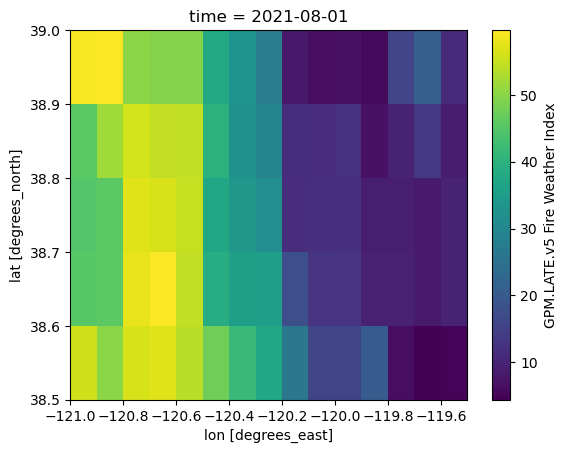

In [35]:
g_fwi  = geos_fwi["GPM.LATE.v5_FWI"]
#g_fwi = g_fwi.rio.set_spatial_dims(x_dim= "lat", y_dim = "lon")
#print(min_lon)
#g_fwi.lon

#gsmall = g_fwi.sel(time ="2021-08", drop = True)

min_lat = 38.5
max_lat = 39.0
min_lon = -121.0 
max_lon = -119.50

gsmall = g_fwi.sel(time ="2021-08", lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon))
gsmall.sel(time = "2021-08-01").plot()
gsmall.sel(lat = foi.lat, lon = foi.lon).plot()


In [15]:


#geos_fwi_sub = g_fwi.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)

#tmp = g_fwi.where((g_fwi.lat > min_lat) & (g_fwi.lat < max_lat), drop=True) #THIS MAXES OUT THE MEMORY

In [21]:
?g_fwi.sel

Signature:
g_fwi.sel(
    indexers: 'Mapping[Any, Any]' = None,
    method: 'str' = None,
    tolerance=None,
    drop: 'bool' = False,
    **indexers_kwargs: 'Any',
) -> 'T_DataArray'
Docstring:
Return a new DataArray whose data is given by selecting index
labels along the specified dimension(s).

In contrast to `DataArray.isel`, indexers for this method should use
labels instead of integers.

Under the hood, this method is powered by using pandas's powerful Index
objects. This makes label based indexing essentially just as fast as
using integer indexing.

It also means this method uses pandas's (well documented) logic for
indexing. This means you can use string shortcuts for datetime indexes
(e.g., '2000-01' to select all values in January 2000). It also means
that slices are treated as inclusive of both the start and stop values,
unlike normal Python indexing.

.. warning::

  Do not try to assign values when using any of the indexing methods
  ``isel`` or ``sel``::

    da = xr.Dat